In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import random
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
data = pd.read_csv('../data/articles_with_topics_assigned.csv')
data.head()

,ID,Content,Topic
0,0,congressional republican new fear come health ...,Legal and Judicial Systems
1,1,bullet shell get counted blood dry votive cand...,Court cases and Crime
2,2,walt disney bambi opened critic praised spare ...,Entertainment and Sports
3,3,death may great equalizer isnt necessarily eve...,Entertainment and Sports
4,4,north korea leader kim said sunday country mak...,International Affairs and Military


In [3]:
topics = data["Topic"]
topics.head()

0            Legal and Judicial Systems
1                 Court cases and Crime
2              Entertainment and Sports
3              Entertainment and Sports
4    International Affairs and Military
Name: Topic, dtype: object

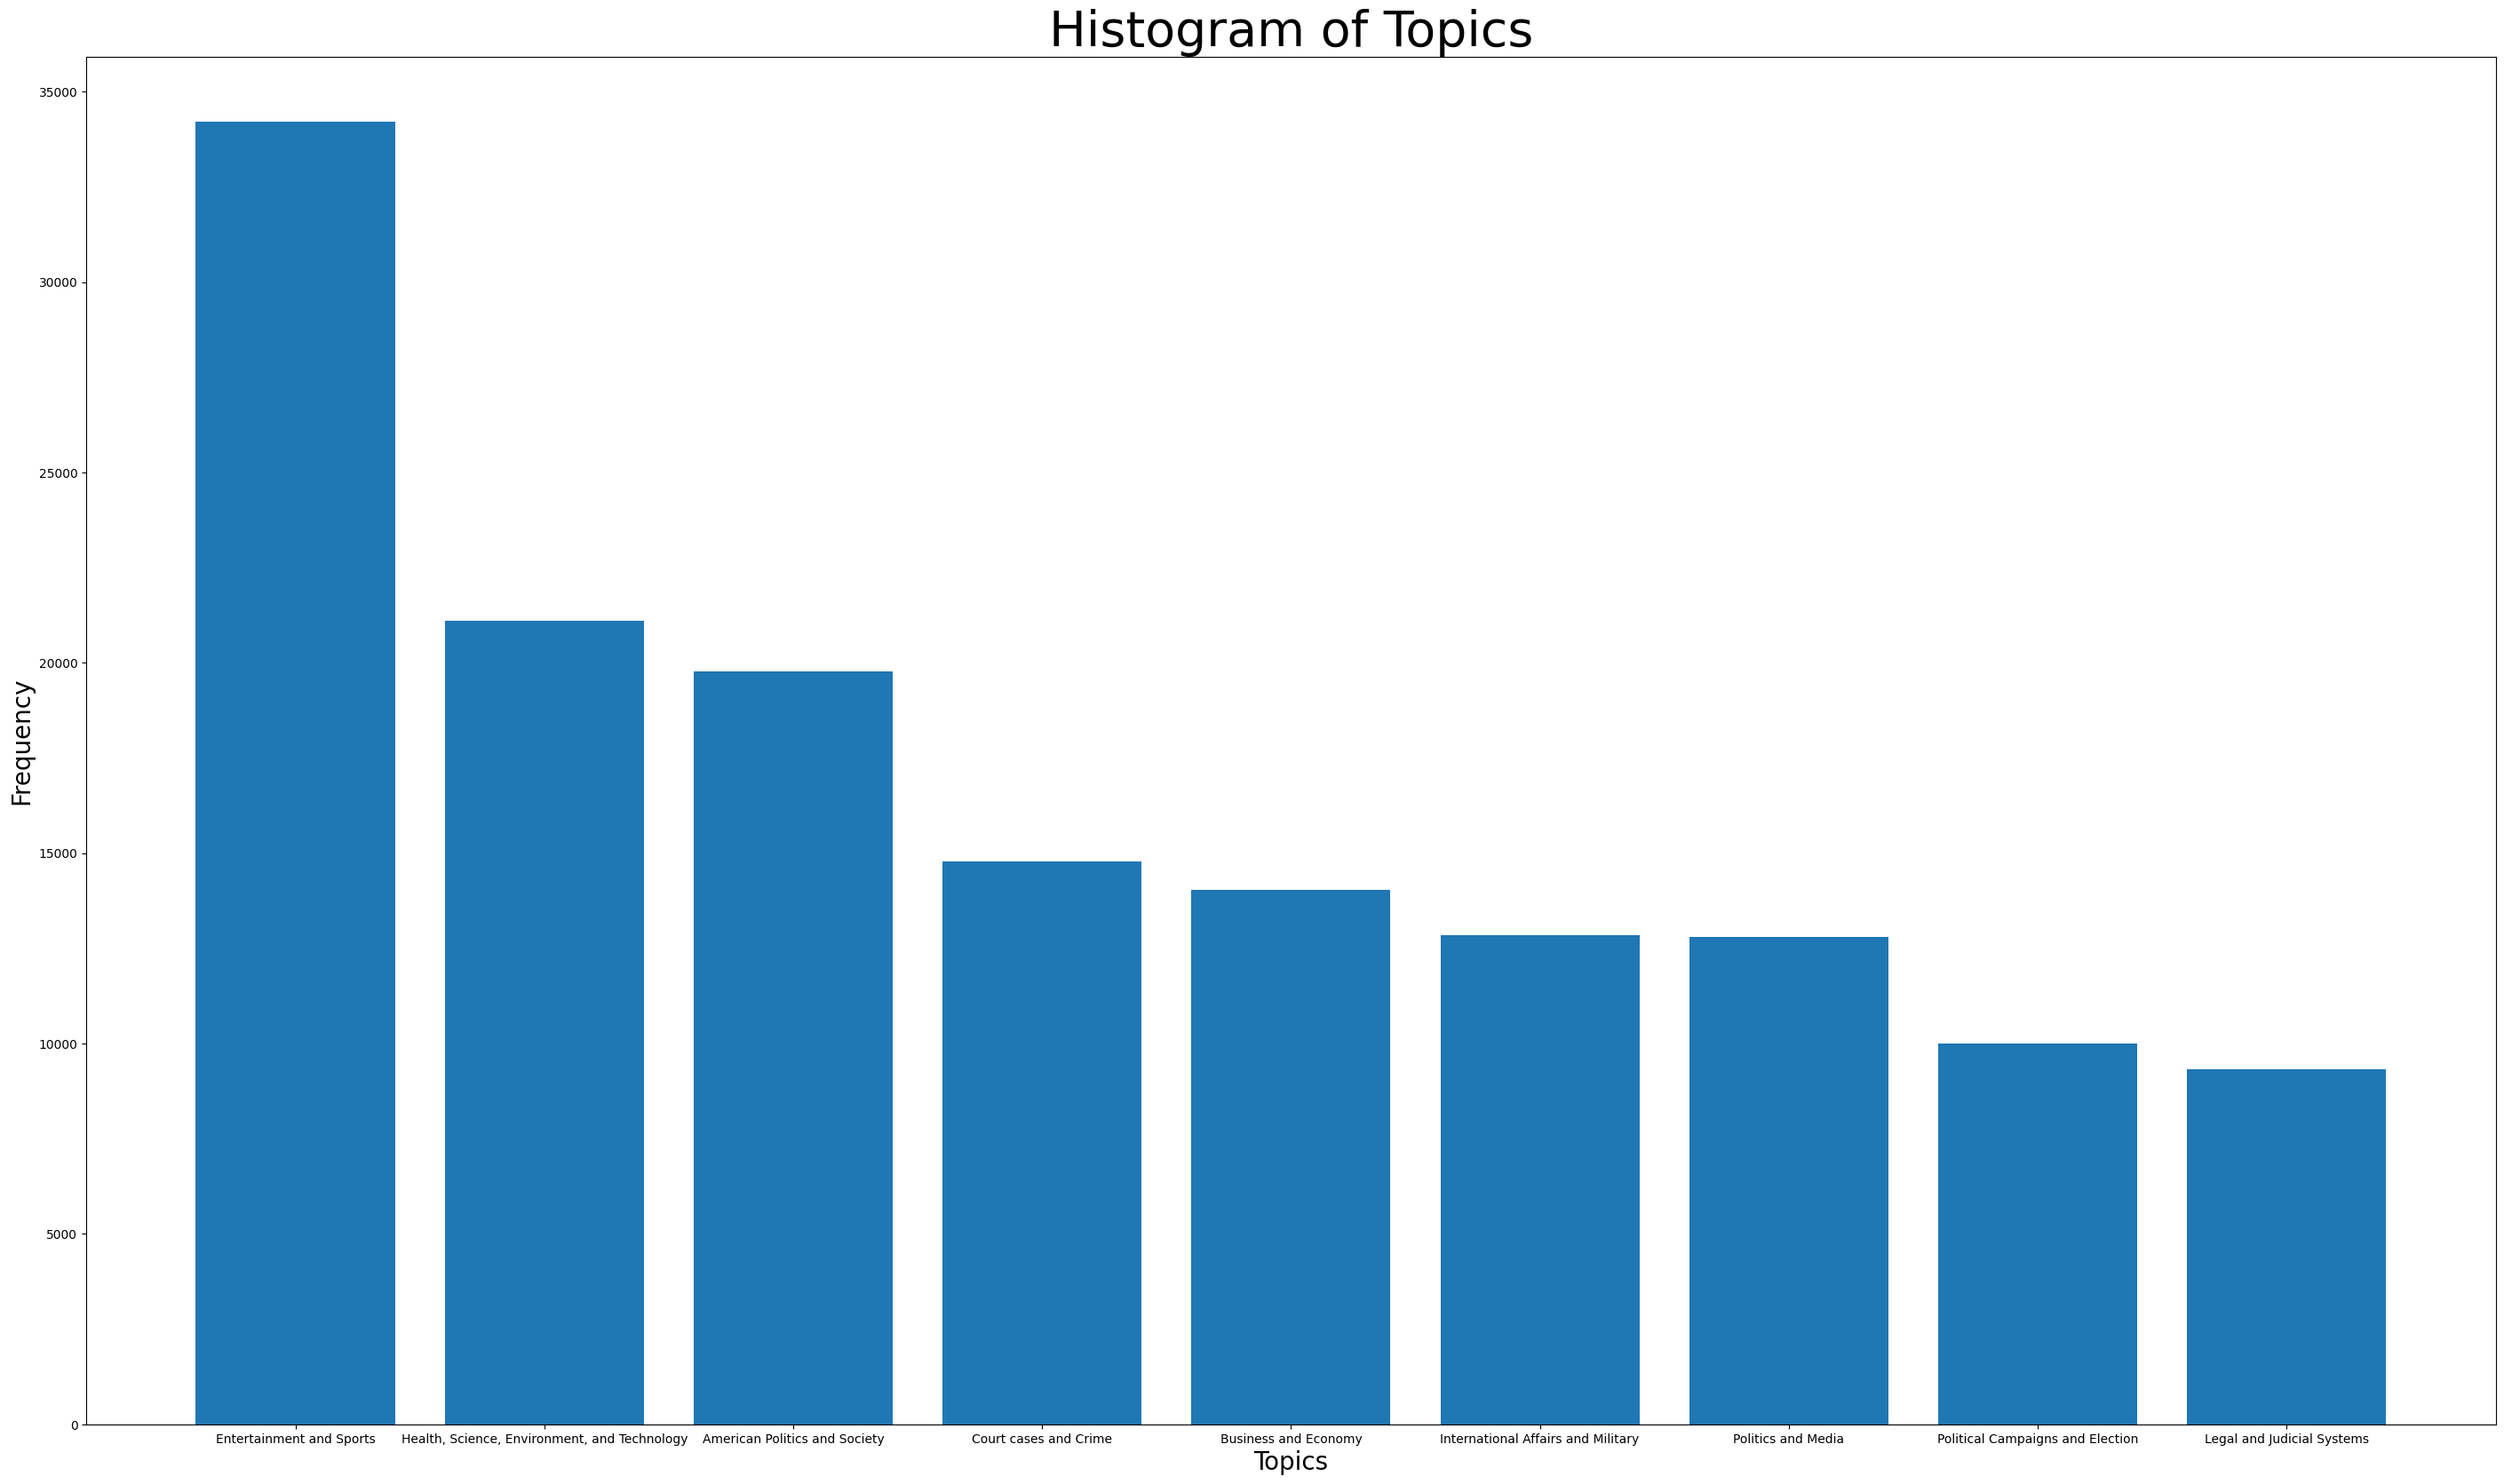

In [4]:
#Histogram of the Dataset

topic_count = topics.value_counts()
plt.figure(figsize=(35, 20))

plt.bar(topic_count.index, topic_count)

plt.xlabel('Topics', fontsize = 20)
plt.ylabel('Frequency', fontsize = 20)
plt.title('Histogram of Topics', fontsize = 40)
plt.show()

In [5]:
contents = data["Content"]
contents.head()

0    congressional republican new fear come health ...
1    bullet shell get counted blood dry votive cand...
2    walt disney bambi opened critic praised spare ...
3    death may great equalizer isnt necessarily eve...
4    north korea leader kim said sunday country mak...
Name: Content, dtype: object

In [6]:
from collections import defaultdict
import json

In [7]:
glove6B100d = defaultdict(int)
all_possible_words_in_file = []
respective_vector = []
file_path = "glove.6B.100d.txt"

with open(file_path, 'r') as file:
  for line in file:
    items = line.split()
    word = items[0]
    all_possible_words_in_file.append(word)
    numbers = [float(num) for num in items[1:]]
    respective_vector.append(numbers)

In [8]:
word_vectors = []
parsed_articles = [line_of_csv.split() for line_of_csv in contents]

In [9]:
print(len(parsed_articles))

148871


In [10]:
all_word_dict = {}
value_count = 0
for article in parsed_articles:
    for word in article:
        if word not in all_word_dict:
            all_word_dict[word] = value_count
            value_count += 1
            
allwordLength = value_count


In [12]:
word_to_glove_zero = {}
for word, value in tqdm(all_word_dict.items()):
    if word in all_possible_words_in_file:
        place = all_possible_words_in_file.index(word)
        word_to_glove_zero[word] = respective_vector[place]
    else:
        word_to_glove_zero[word] = [0 for x in range(100)]

100%|██████████| 450289/450289 [46:01<00:00, 163.04it/s] 


In [13]:
with open('linear_word_to_glove_zero.json', 'w') as file:
    json.dump(word_to_glove_zero, file)

In [11]:
with open('linear_word_to_glove_zero.json', 'r') as file:
    word_to_glove_zero = json.load(file)

In [57]:
word_vectors_zero = []

for x in tqdm(parsed_articles):
    count = 0
    each_article_zero = np.zeros(100)
    
    for word in x:
        count += 1
        each_article_zero += word_to_glove_zero[word]
    
    average_article_zero = [number/count for number in each_article_zero]
    word_vectors_zero.append(average_article_zero)

100%|██████████| 148871/148871 [05:12<00:00, 477.10it/s]


In [17]:
with open('linear_word_floats_zero.json', 'w') as f:
    json.dump(word_vectors_zero, f)

In [12]:
with open('linear_word_floats_zero.json', 'r') as f:
    word_vectors_zero = json.load(f)

In [13]:
print(len(word_vectors_zero))

148871


In [14]:
topic_lst = topics.tolist()
X = word_vectors_zero
topic_lst = np.array(topic_lst)
mapping = {'Legal and Judicial Systems': 0, 'Court cases and Crime': 1, 'International Affairs and Military': 2, 
           'American Politics and Society': 3, 'Entertainment and Sports': 4, 'Health, Science, Environment, and Technology': 5,
           'Business and Economy': 6, 'Politics and Media': 7, 'Political Campaigns and Election': 8}
topic_val_lst = [mapping[t] for t in topic_lst]

Y = np.zeros((len(topic_val_lst), len(mapping)))
Y[np.arange(len(topic_val_lst)), topic_val_lst] = 1
print(Y.shape)

(148871, 9)


In [15]:
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

print(X.shape)
print(Y.shape)

torch.Size([148871, 100])
torch.Size([148871, 9])


In [16]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [17]:
def separate_data(X,Y,per_val = 0.1, per_test = 0.1):
    N = len(X)
    len_validation = int(per_val*N)
    len_test = int(per_test*N)
    len_train = N - len_validation - len_test

    len_t_v = len_train+len_validation

    X_train = X[:len_train]
    Y_train = Y[:len_train]
    X_validation = X[len_train:len_t_v]
    Y_validation = Y[len_train:len_t_v]
    X_test = X[len_t_v:]
    Y_test = Y[len_t_v:]

    return (X_train,Y_train,X_validation,Y_validation,X_test,Y_test)

trainX, trainY, valX, valY, testX, testY = separate_data(X,Y,0.2,0.1)





In [18]:
from torch.utils.data import random_split,Dataset,DataLoader
class TopicDataset(Dataset):
    def __init__(self, X, Y):
        self.X_G = X
        self.Y_G = Y

    def __len__(self):
        return len(self.X_G)

    def __getitem__(self,idx):
        return self.X_G[idx], self.Y_G[idx]

In [19]:
from torch.utils.data import random_split,Dataset,DataLoader

batch_size = 256

ds_train = TopicDataset(trainX, trainY)
ds_val = TopicDataset(valX, valY)
ds_test = TopicDataset(testX, testY)

glove_training_dataloader = DataLoader(ds_train, batch_size = batch_size, shuffle = True)
glove_validation_dataloader = DataLoader(ds_val, batch_size = batch_size, shuffle = True)
glove_testing_dataloader = DataLoader(ds_test, batch_size = batch_size, shuffle = False)

In [20]:
from torch import nn, optim
import torch.nn.functional as F
class GloveModel(nn.Module):
    
    def __init__(self, dimOne, dimTwo, dropOut):
        super(GloveModel,self).__init__()
        self.hidden_layer1 = nn.Linear(100, dimOne)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = dropOut)
        self.hidden_layer2 = nn.Linear(dimOne,dimTwo)
        self.hidden_layer3 = nn.Linear(dimTwo, 9)
        
        

    def forward(self,x):
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        
        
        
        return x

In [21]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss,label='Training',color='g')
    plt.plot(validation_loss,label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
#     plt.ylim(-0.1,(max(max(training_loss),max(validation_loss))*1.1) )
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[-1],6))
    print('Final Validation Loss:',np.around(validation_loss[-1],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy,label='Training',color='g')
    plt.plot(validation_accuracy,label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
#     plt.ylim(-0.1,1.1)
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[-1],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[-1],6))
    print()

    print("Test Accuracy:", test_accuracy.item())
    print()

100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


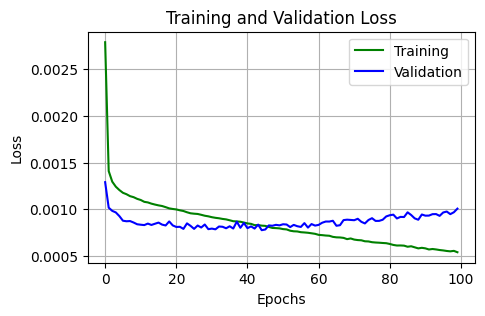

Final Training Loss:   0.000539
Final Validation Loss: 0.001006


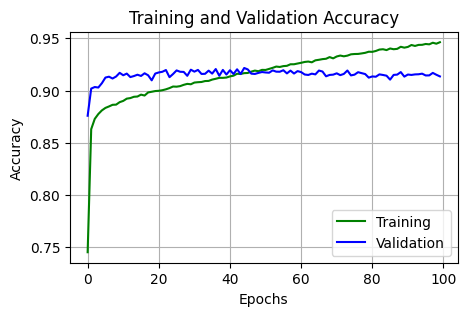

Final Training Accuracy:   0.946301
Final Validation Accuracy: 0.913582

Test Accuracy: 0.9048835039138794



In [55]:
glove_model = GloveModel(256, 64, 0)
glove_model = glove_model.float().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 100
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in glove_training_dataloader:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim=1)).float().sum()

    training_losses[epoch]   = t_loss/len(trainX)
    training_accuracy[epoch] = t_num_correct/len(trainX)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(valX)
    val_accuracy[epoch] = v_num_correct/len(valX)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]




save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)


In [56]:
torch.save(save_model, "three_linear_model_one.pth")

100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


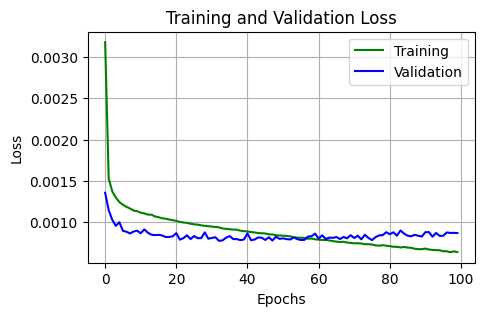

Final Training Loss:   0.000639
Final Validation Loss: 0.00087


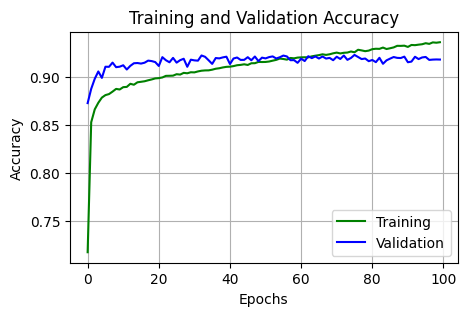

Final Training Accuracy:   0.935534
Final Validation Accuracy: 0.917579

Test Accuracy: 0.9085108041763306



In [57]:
glove_model = GloveModel(256, 32, 0)
glove_model = glove_model.float().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 100
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in glove_training_dataloader:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim=1)).float().sum()

    training_losses[epoch]   = t_loss/len(trainX)
    training_accuracy[epoch] = t_num_correct/len(trainX)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(valX)
    val_accuracy[epoch] = v_num_correct/len(valX)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]




save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)


In [58]:
torch.save(save_model, "three_linear_model_two.pth")

100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


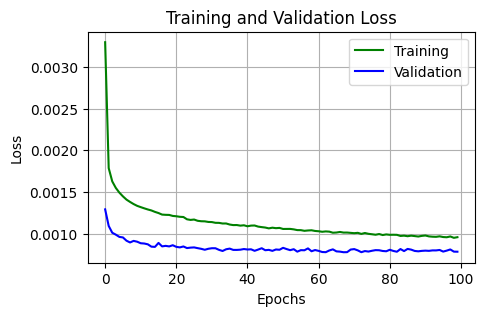

Final Training Loss:   0.000958
Final Validation Loss: 0.000784


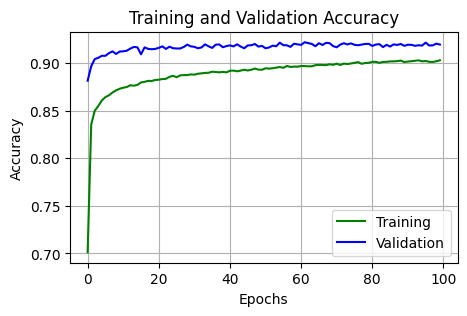

Final Training Accuracy:   0.903147
Final Validation Accuracy: 0.919661

Test Accuracy: 0.9102572798728943



In [59]:
glove_model = GloveModel(256, 64, 0.3)
glove_model = glove_model.float().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 100
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in glove_training_dataloader:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim=1)).float().sum()

    training_losses[epoch]   = t_loss/len(trainX)
    training_accuracy[epoch] = t_num_correct/len(trainX)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(valX)
    val_accuracy[epoch] = v_num_correct/len(valX)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]




save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)


In [60]:
torch.save(save_model, "three_linear_model_three.pth")

In [28]:
from torch import nn, optim
import torch.nn.functional as F
class GloveModel(nn.Module):
    
    def __init__(self, dimOne, dimTwo, dimThree, dropOut):
        super(GloveModel,self).__init__()
        self.hidden_layer1 = nn.Linear(100, dimOne)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = dropOut)
        self.hidden_layer2 = nn.Linear(dimOne,dimTwo)
        
        self.hidden_layer3 = nn.Linear(dimTwo, dimThree)
        self.hidden_layer4 = nn.Linear(dimThree, 9)
        
        

    def forward(self,x):
        x = self.hidden_layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden_layer4(x)
        
        
        
        return x

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


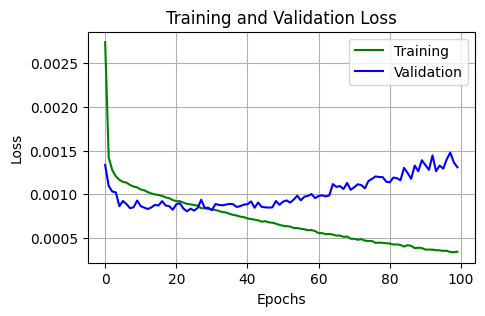

Final Training Loss:   0.000342
Final Validation Loss: 0.001309


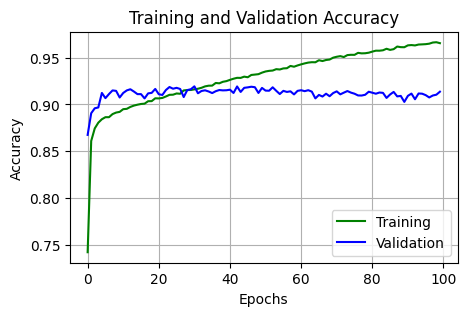

Final Training Accuracy:   0.965426
Final Validation Accuracy: 0.913582

Test Accuracy: 0.900382936000824



In [39]:
glove_model = GloveModel(256, 64, 256, 0)
glove_model = glove_model.float().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 100
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in glove_training_dataloader:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim=1)).float().sum()
        

    training_losses[epoch]   = t_loss/len(trainX)
    training_accuracy[epoch] = t_num_correct/len(trainX)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(valX)
    val_accuracy[epoch] = v_num_correct/len(valX)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]




save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)


In [40]:
torch.save(save_model, "three_linear_model_four.pth")

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


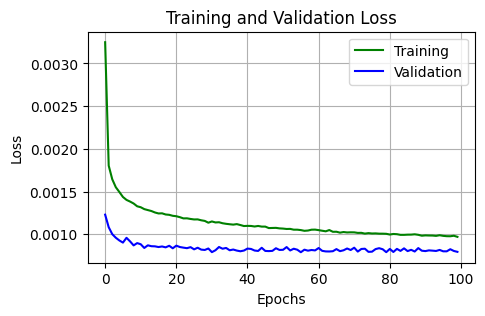

Final Training Loss:   0.00097
Final Validation Loss: 0.000794


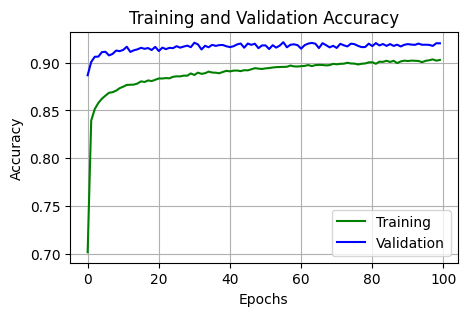

Final Training Accuracy:   0.902802
Final Validation Accuracy: 0.920232

Test Accuracy: 0.9111977219581604



In [43]:
glove_model = GloveModel(256, 64, 256, 0.3)
glove_model = glove_model.float().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(glove_model.parameters(), lr = 0.001)
num_epochs = 100
training_losses = np.zeros(num_epochs)
val_losses      = np.zeros(num_epochs)

training_accuracy = np.zeros(num_epochs)
val_accuracy      = np.zeros(num_epochs)

save_model_val = float(0)
save_model = None

for epoch in tqdm(range(num_epochs)):
    
    # Training here
    glove_model.train()
    t_loss = 0.0
    t_num_correct = 0

    for X_train_batch,Y_train_batch in glove_training_dataloader:
        X_train_batch = X_train_batch.to(device)
        Y_train_batch = Y_train_batch.to(device)
        optimizer.zero_grad()
        Y_train_hat = glove_model(X_train_batch)
        loss = loss_fn(Y_train_hat,Y_train_batch)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_num_correct += (torch.argmax(Y_train_hat,dim=1) == torch.argmax(Y_train_batch, dim=1)).float().sum()
        

    training_losses[epoch]   = t_loss/len(trainX)
    training_accuracy[epoch] = t_num_correct/len(trainX)

      # Validation section
    v_loss = 0.0
    glove_model.eval()
    v_num_correct = 0

    for X_val_batch,Y_val_batch in glove_validation_dataloader:
        X_val_batch = X_val_batch.to(device)
        Y_val_batch = Y_val_batch.to(device)
        Y_hat_val = glove_model(X_val_batch)
        loss = loss_fn(Y_hat_val,Y_val_batch)
        v_loss += loss.item()

        v_num_correct += (torch.argmax(Y_hat_val,dim=1) == torch.argmax(Y_val_batch, dim=1)).float().sum()

    val_losses[epoch]   = v_loss/len(valX)
    val_accuracy[epoch] = v_num_correct/len(valX)
    if val_accuracy[epoch] > save_model_val:
        torch.save(glove_model, 'glove_model.pth')
        save_model_var = val_accuracy[epoch]




save_model = torch.load('glove_model.pth')
  # testing section
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy)


In [44]:
torch.save(save_model, "three_linear_model_five.pth")

In [45]:
save_model = torch.load("three_linear_model_five.pth")
num_correct_test = 0
save_model.eval()

for X_test_batch,Y_test_batch in glove_testing_dataloader:
    X_test_batch = X_test_batch.to(device)
    Y_test_batch = Y_test_batch.to(device)
    Y_hat_test = save_model(X_test_batch)
    num_correct_test += (torch.argmax(Y_hat_test,dim=1) == torch.argmax(Y_test_batch, dim = 1)).float().sum()

test_accuracy = num_correct_test / len(testX)
print(test_accuracy)

tensor(0.9112, device='cuda:0')


In [46]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


y_true = topic_val_lst

majority_class = max(set(y_true), key=y_true.count)
y_pred_baseline = [majority_class] * len(y_true)

baseline_accuracy = accuracy_score(y_true, y_pred_baseline)
precision = precision_score(y_true, y_pred_baseline, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred_baseline, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred_baseline, average='macro', zero_division=0)

print(f"Baseline accuracy is {baseline_accuracy}")
print(f"Baseline precision is {precision}")
print(f"Baseline recall is {recall}")
print(f"Baseline F1 score is {f1}")


Baseline accuracy is 0.22981641824129614
Baseline precision is 0.025535157582366238
Baseline recall is 0.1111111111111111
Baseline F1 score is 0.04152677945035552


In [47]:
print(f"The accuracy of the linear model is {test_accuracy}")
print(f"Percentage above the baseline is {test_accuracy - baseline_accuracy}")
print(f"Cohen's Kappa is {(test_accuracy-baseline_accuracy)/(1-baseline_accuracy)}")

The accuracy of the linear model is 0.9111977219581604
Percentage above the baseline is 0.6813812851905823
Cohen's Kappa is 0.8846998810768127


In [48]:
y_true = torch.argmax(Y_hat_test,dim=1).cpu().numpy()
y_pred = torch.argmax(Y_test_batch,dim=1).cpu().numpy()  

In [49]:
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"The precision of the linear model is {precision}")
print(f"The recall of the linear model is {recall}")
print(f"F1 score of the linear model is {f1}")

The precision of the linear model is 0.7878787878787878
The recall of the linear model is 0.84375
F1 score of the linear model is 0.7374358974358974
